# PRCP-1006 - Home Loan Default - Risk Management Notebook 2
    
    By: PTID-CDS-JAN22-1266
        Guiller Fiestada
                              

# 4. Data Cleaning and Feature Engineering

### Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# data wrangling & pre-processing
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#model validation
from sklearn.metrics import confusion_matrix , accuracy_score , recall_score ,precision_score , f1_score 
from sklearn.metrics import log_loss,roc_auc_score,roc_curve,auc

#data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# File system manangement
import os
import gc       # garbage collection

# clear out any old junk
gc.collect()

pd.set_option('display.max_columns', None) #to show all columns
pd.set_option('display.max_rows', None) #to show all rows

### Dataset

In [2]:
appli_train  =  pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_bal = pd.read_csv('bureau_balance.csv')
credit_card_bal = pd.read_csv('credit_card_balance.csv')
installment = pd.read_csv('installments_payments.csv')
pos_bal = pd.read_csv('POS_CASH_balance.csv')
prev_appli = pd.read_csv('previous_application.csv')

### bureau_balance.csv
load bureau_balance.csv, make two pivot tables (one for overall, one for last 12 months only) - all we can do with them is merge them into bureau using SK_ID_BUREAU because we are not given SK_ID_CURR in this table.

In [3]:
                                     
print(bureau_bal.shape, "- shape of bureau_balance table")
bb_status = pd.crosstab(bureau_bal.SK_ID_BUREAU, bureau_bal.STATUS, margins = True)             # create pivot table
bb_status.columns = ['BB_'+column for column in bb_status.columns]
print(bb_status.shape, "- shape of bb_status table")
bureau_bal_12 = bureau_bal[bureau_bal.MONTHS_BALANCE > -24]                                 # filter - last 12 months only
bb_status_12 = pd.crosstab(bureau_bal_12.SK_ID_BUREAU, bureau_bal_12.STATUS, margins = True)    # pivot table on filtered data
bb_status_12.columns = ['BB12_'+column for column in bb_status_12.columns]
print(bb_status_12.shape, "- shape of bb_status_12 table")

del bureau_bal           # we are keeping bb_status and bb_status_12, dropping the original table and the filtered version
del bureau_bal_12
gc.collect()

(27299925, 3) - shape of bureau_balance table
(817396, 9) - shape of bb_status table
(721535, 9) - shape of bb_status_12 table


0

### bureau.csv
we will create bureau_num, bureau_cat and bureau_count - these will later be merged into application_train data

In [4]:
print(bureau.shape, "- shape of bureau table")

bureau = bureau.merge(bb_status, left_on = 'SK_ID_BUREAU', right_on = 'SK_ID_BUREAU')               # merge the tables
bureau = bureau.merge(bb_status_12, left_on = 'SK_ID_BUREAU', right_on = 'SK_ID_BUREAU')            # merge the tables
bureau = bureau.drop(['SK_ID_BUREAU'], axis = 1)                                                    # no longer need this key id feature
print(bureau.shape, "- shape of bureau table after merging in bb_status tables")                   
bureau.columns = ['BU_'+column if column !='SK_ID_CURR' else column for column in bureau.columns]   # things that start with BU_ came from bureau

# ratio features
bureau['OD_ratio'] = bureau['BU_AMT_CREDIT_SUM_OVERDUE'] / bureau['BU_AMT_CREDIT_SUM_DEBT']   # proportion of debt that is overdue
bureau['Credit_ratio'] = bureau['BU_AMT_CREDIT_SUM'] / bureau['BU_AMT_CREDIT_SUM_LIMIT']      # proportion of credit line used
bureau['Debt_ratio'] = bureau['BU_AMT_CREDIT_SUM_DEBT'] / bureau['BU_AMT_CREDIT_SUM']         # debt percentage
bureau['REMAIN_CRED'] = bureau['BU_AMT_CREDIT_SUM'] - bureau['BU_AMT_CREDIT_SUM_DEBT'] - bureau['BU_AMT_CREDIT_SUM_LIMIT']
bureau['AC_RATIO'] = bureau['BU_AMT_ANNUITY'] / bureau['BU_AMT_CREDIT_SUM']

# numeric features for bureau
bureau_num = bureau.groupby(by=['SK_ID_CURR']).mean().reset_index()                                 # group the numeric features by SK_ID_CURR
print(bureau_num.shape, "- shape of numeric bureau features (incl index)")                          

# categorical feagures for bureau
bureau_cat = pd.get_dummies(bureau.select_dtypes('object'))                                         # this got rid of the SK_ID_CURR column ...
bureau_cat['SK_ID_CURR'] = bureau['SK_ID_CURR']                                                     # so we have to replace it
bureau_cat = bureau_cat.groupby(by = ['SK_ID_CURR']).mean().reset_index()                           # tried sum - didn't change anything
print(bureau_cat.shape, "- shape of categorical bureau features (incl index)")                     

# count feature for bureau
bureau_count = bureau.groupby(by = ['SK_ID_CURR'])['BU_CREDIT_ACTIVE'].count().reset_index()
bureau_count.rename(columns={'BU_CREDIT_ACTIVE':'COUNT_of_BUREAU'})   

# we are keeping bureau_num, bureau_cat and bureau_count - all will be merged into training data
del bureau                   # no longer need this table - its contents were transformed into bureau_num, bureau_cat, bureau_count
del bb_status                # no longer need this table - already merged into bureau
del bb_status_12             # no longer need this table - already merged into bureau
gc.collect()

(1716428, 17) - shape of bureau table
(693550, 34) - shape of bureau table after merging in bb_status tables
(133231, 36) - shape of numeric bureau features (incl index)
(133231, 23) - shape of categorical bureau features (incl index)


26

### credit_card_balance.csv

In [5]:
credit_card_bal.drop(['SK_ID_PREV'], axis=1, inplace = True)
credit_card_bal.columns = ['CC_'+column if column != 'SK_ID_CURR' else column for column in credit_card_bal.columns]

credit_card_bal['DRAW_RATIO'] = credit_card_bal['CC_AMT_DRAWINGS_CURRENT'] / credit_card_bal['CC_CNT_DRAWINGS_CURRENT']
credit_card_bal['RECEIVE_RATIO'] = credit_card_bal['CC_AMT_RECIVABLE'] / credit_card_bal['CC_AMT_RECEIVABLE_PRINCIPAL']
credit_card_bal['RECEIVE_PER'] = credit_card_bal['CC_AMT_RECIVABLE'] / credit_card_bal['CC_AMT_TOTAL_RECEIVABLE']

credit_card_bal_num = credit_card_bal.groupby(by=['SK_ID_CURR']).mean().reset_index()            # group the numeric features by SK_ID_CURR
print(credit_card_bal_num.shape, "- shape of numeric features (incl index)")         

credit_card_bal_cat = pd.get_dummies(credit_card_bal.select_dtypes('object'))                    # this got rid of the SK_ID_CURR column ...
credit_card_bal_cat['SK_ID_CURR'] = credit_card_bal['SK_ID_CURR']                                # so we have to replace it
credit_card_bal_cat = credit_card_bal_cat.groupby(by = ['SK_ID_CURR']).mean().reset_index()      # could try sum as well.
print(credit_card_bal_cat.shape, "- shape of categorical features (incl index)")     

# we will keep credit_card_bal_num and credit_card_bal_cat
del credit_card_bal
gc.collect()

(103558, 24) - shape of numeric features (incl index)
(103558, 8) - shape of categorical features (incl index)


28

### installment_payments.csv

only contains numeric features. we will create installment_num, which will later be merged into application_train dataset

In [6]:
installment.drop(['SK_ID_PREV'], axis=1, inplace = True)
installment.columns = ['IP_'+column if column != 'SK_ID_CURR' else column for column in installment.columns]

installment['PAY_PERCENT'] = installment['IP_AMT_INSTALMENT'] / installment['IP_AMT_PAYMENT']
installment['PAY_DIFF'] = installment['IP_AMT_INSTALMENT'] - installment['IP_AMT_PAYMENT']
installment['DPD'] = installment['IP_DAYS_ENTRY_PAYMENT'] - installment['IP_DAYS_INSTALMENT']
installment['DPD'] = installment['DPD'].apply(lambda x: x if x>0 else 0)
installment['DBD'] = installment['IP_DAYS_INSTALMENT'] - installment['IP_DAYS_ENTRY_PAYMENT']
installment['DBD'] = installment['DBD'].apply(lambda x: x if x>0 else 0)

installment_num = installment.groupby(by=['SK_ID_CURR']).mean().reset_index()         # group the numeric features by SK_ID_CURR
print(installment_num.shape, "- shape of numeric features (incl index)")       

# we will keep installment_num and get rid of installment
del installment                  # don't need this anymore
gc.collect()

(339587, 11) - shape of numeric features (incl index)


15

#### POS_CASH_balance.csv
we will create pos_num and pos_cat - these will later be merged into application_train dataset

In [7]:

pos_bal.drop(['SK_ID_PREV'], axis=1, inplace = True)
pos_bal.columns = ['PO_'+column if column != 'SK_ID_CURR' else column for column in pos_bal.columns]

pos_num = pos_bal.groupby(by=['SK_ID_CURR']).mean().reset_index()            # group the numeric features by SK_ID_CURR
print(pos_num.shape, "- shape of numeric features (incl index)")         

pos_cat = pd.get_dummies(pos_bal.select_dtypes('object'))                    # this got rid of the SK_ID_CURR column ...
pos_cat['SK_ID_CURR'] = pos_bal['SK_ID_CURR']                                # so we have to replace it
pos_cat = pos_cat.groupby(by = ['SK_ID_CURR']).mean().reset_index()      # could try sum as well.
print(pos_cat.shape, "- shape of categorical features (incl index)")     

# we will keep pos_num and pos_cat
del pos_bal
gc.collect()

(337252, 6) - shape of numeric features (incl index)
(337252, 10) - shape of categorical features (incl index)


15

### previous_application.csv
we will create previous_num and previous_cat - these will later be merged into application_train dataset

In [8]:
pip install numpy-financial

In [9]:
#creating function for CALC_RATE, INTEREST_PAID and INT_PRINC.
import numpy_financial as npf

def calc_rate(row):
    return npf.rate(row['CNT_PAYMENT'], -row['AMT_ANNUITY'], row['AMT_CREDIT'], 0, guess = 0.05, maxiter = 10)


prev_appli['CALC_RATE'] = prev_appli.apply(calc_rate, axis=1)
prev_appli['INTEREST_PAID'] = prev_appli['AMT_ANNUITY'] * prev_appli['CNT_PAYMENT'] - prev_appli['AMT_CREDIT']
prev_appli['INT_PRINC'] = prev_appli['INTEREST_PAID'] / prev_appli['AMT_CREDIT']



In [10]:
print(prev_appli.shape)
prev_appli.drop(['SK_ID_PREV'], axis=1, inplace = True)
prev_appli.columns = ['PR_'+column if column !='SK_ID_CURR' else column for column in prev_appli.columns]

prev_appli['PR_DAYS_LAST_DUE'].replace({365243: np.nan}, inplace = True)
prev_appli['PR_DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace = True)
prev_appli['PR_DAYS_FIRST_DUE'].replace(365243, np.nan, inplace = True)
prev_appli['PR_DAYS_TERMINATION'].replace({365243: np.nan}, inplace = True)
prev_appli['PR_DAYS_FIRST_DRAWING'].replace({365243: np.nan}, inplace = True)
prev_appli['PR_CApp_RATIO'] = prev_appli['PR_AMT_CREDIT'] / prev_appli['PR_AMT_APPLICATION'] 
prev_appli['PR_AG_RATIO'] = prev_appli['PR_AMT_APPLICATION'] / prev_appli['PR_AMT_GOODS_PRICE'] 
prev_appli['PR_CAnnRATIO'] = prev_appli['PR_AMT_CREDIT'] / prev_appli['PR_AMT_ANNUITY'] 
prev_appli['PR_CG_RATIO'] = prev_appli['PR_AMT_CREDIT'] / prev_appli['PR_AMT_GOODS_PRICE'] 

# Create numeric features by grouping on SK_ID_CURR and finding group means
previous_num = prev_appli.groupby(by=['SK_ID_CURR']).mean().reset_index()         # group the numeric features by SK_ID_CURR
print(previous_num.shape, "- shape of numeric features (incl index)")         

# Create categorical features by creating dummies and then taking group means
previous_cat = pd.get_dummies(prev_appli.select_dtypes('object'))                 # this got rid of the SK_ID_CURR column ...
previous_cat['SK_ID_CURR'] = prev_appli['SK_ID_CURR']                             # so we have to replace it
previous_cat = previous_cat.groupby(by = ['SK_ID_CURR']).mean().reset_index()   # could try sum as well.
print(previous_cat.shape, "- shape of categorical features (incl index)")     

# we can keep previous_num and previous_cat - these will be merged into application_train data
del prev_appli                # no longer need this table - its contents were transformed into previous_num, previous_cat
                
gc.collect()

(1670214, 40)
(338857, 27) - shape of numeric features (incl index)
(338857, 144) - shape of categorical features (incl index)


0

### application_train.csv
we will create new feature based on the data observation and encode categorical feature through label encoder and one hot encoder then we will merge all numerical and categorical data from bureau, credit card balance, istallment, pos cash balance and previous application

In [11]:
# clean up days employed and replaced the Nan values
appli_train['FLAG_365243'] = appli_train['DAYS_EMPLOYED'] == 365243            # these people are mostly pensioners
appli_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)         # DAYS_EMPLOYED is a powerful feature 

# Removing errors with XNA CODE_GENDER and unknown family status
appli_train = appli_train[appli_train['CODE_GENDER'] != 'XNA']
appli_train = appli_train[appli_train.NAME_FAMILY_STATUS != "Unknown"] 

# Deleting FLAG_MOBIL because there is only 1 person without mobile phone
appli_train.drop('FLAG_MOBIL', axis=1, inplace=True)
appli_train.drop('FLAG_CONT_MOBILE', axis=1, inplace=True)

# Changing rare categories of NAME_INCOME_TYPE with the similar categories
appli_train.loc[appli_train['NAME_INCOME_TYPE'] == 'Student', 'NAME_INCOME_TYPE'] = 'State servant'
appli_train.loc[appli_train['NAME_INCOME_TYPE'] == 'Maternity leave', 'NAME_INCOME_TYPE'] = 'Pensioner'
appli_train.loc[appli_train['NAME_INCOME_TYPE'] == 'Unemployed', 'NAME_INCOME_TYPE'] = 'Pensioner'
appli_train.loc[appli_train['NAME_INCOME_TYPE'] == 'Businessman', 'NAME_INCOME_TYPE'] = 'Commercial associate'

# Rare Encoding NAME_HOUSING_TYPE with 'Other'
appli_train.loc[(appli_train['NAME_HOUSING_TYPE'] == 'Office apartment') &
       (appli_train['NAME_HOUSING_TYPE'] == 'Co-op apartment'), 'NAME_HOUSING_TYPE'] = 'Other'

#  Changing unknown family status with the most observed category
appli_train['NAME_FAMILY_STATUS'].replace('Unknown', 'Married', inplace=True)

#  Changing HOUSETYPE_MODE not null values with
appli_train.loc[appli_train['HOUSETYPE_MODE'].notnull(), 'HOUSETYPE_MODE'] = 'house_type_reported'

# # Some simple new features (percentages)
appli_train['CI_ratio'] = appli_train['AMT_CREDIT'] / appli_train['AMT_INCOME_TOTAL']        # credit-to-income ratio
appli_train['AI_ratio'] = appli_train['AMT_ANNUITY'] / appli_train['AMT_INCOME_TOTAL']       # annuity-to-income ratio
appli_train['AC_ratio'] = appli_train['AMT_CREDIT'] / appli_train['AMT_ANNUITY']             # credit to annuity - basically the term of the loan in years
appli_train['CG_ratio'] = appli_train['AMT_CREDIT'] / appli_train['AMT_GOODS_PRICE']         # credit to goods price ratio - how much was financed?

# log features
appli_train['log_INCOME'] = np.log(appli_train['AMT_INCOME_TOTAL'])                    # log of income
appli_train['log_ANNUITY'] = np.log(appli_train['AMT_ANNUITY'])                        # log of annuity
appli_train['log_CREDIT'] = np.log(appli_train['AMT_CREDIT'])                          # log of credit
appli_train['log_GOODS'] = np.log(appli_train['AMT_GOODS_PRICE'])                      # log of goods price

# flag features
appli_train['FLAG_CG_ratio'] = appli_train['AMT_CREDIT'] > appli_train['AMT_GOODS_PRICE']     # FLAG if you borrowed more than the price of the item
appli_train['DAYS_ID_4200'] = appli_train['DAYS_ID_PUBLISH'] < -4200                   # IDs more than about 14 years old are from USSR

appli_train.shape

(307505, 131)

In [12]:
# continuation

# EXT SOURCE MEAN FROM OTHER ASSOCIATIONS 
appli_train["NEW_EXT_MEAN"] = appli_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
appli_train['NEW_APP_EXT_SOURCES_PROD'] = appli_train['EXT_SOURCE_1'] * appli_train['EXT_SOURCE_2'] * appli_train['EXT_SOURCE_3']

# The total credit amount of the product to be purchased
appli_train["NEW_GOODS_CREDIT"] = appli_train["AMT_GOODS_PRICE"] / appli_train["AMT_CREDIT"]

# The ratio of the loan's annual payment to the customer's total income
appli_train['NEW_ANNUITY_INCOME_PERC'] = appli_train['AMT_ANNUITY'] / appli_train['AMT_INCOME_TOTAL']

# The ratio of the difference between the product and the loan to the total annual income
appli_train["NEW_C_GP"] = (appli_train["AMT_GOODS_PRICE"] - appli_train["AMT_CREDIT"]) / appli_train["AMT_INCOME_TOTAL"]

# Age based on days of birth
appli_train["NEW_APP_AGE"] = round(appli_train["DAYS_BIRTH"] * -1 / 365)

appli_train.shape

(307505, 137)

In [13]:
#Encoding categorical Features applying label encoder for the features that contains only 2 category

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in appli_train:
    if appli_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(appli_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(appli_train[col])
            # Transform the data
            appli_train[col] = le.transform(appli_train[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

5 columns were label encoded.


In [14]:
# one-hot encoding of categorical variables
appli_train = pd.get_dummies(appli_train, drop_first=True)


print('Training Features shape: ', appli_train.shape)

Training Features shape:  (307505, 238)


## Merging all features

In [15]:
DFs_to_merge = [bureau_cat, bureau_count, bureau_num, credit_card_bal_cat, credit_card_bal_num,
 installment_num, pos_cat, pos_num, previous_cat, previous_num]

for i in range (0, len(DFs_to_merge)):
    appli_train = appli_train.merge(DFs_to_merge[i], on='SK_ID_CURR', how='left')

print(appli_train.shape, "- shape of data after all merges") 

# get rid of any +/- infinity we might have missed
appli_train.replace([np.inf, -np.inf], 0, inplace = True)

del bureau_cat
del bureau_count
del bureau_num
del credit_card_bal_cat
del credit_card_bal_num
del installment_num
del pos_cat
del pos_num
del previous_cat
del previous_num
gc.collect()

(307505, 519) - shape of data after all merges


0

In [16]:
#Checking missing values

appli_train.isnull().sum()

SK_ID_CURR                                                             0
TARGET                                                                 0
NAME_CONTRACT_TYPE                                                     0
CODE_GENDER                                                            0
FLAG_OWN_CAR                                                           0
FLAG_OWN_REALTY                                                        0
CNT_CHILDREN                                                           0
AMT_INCOME_TOTAL                                                       0
AMT_CREDIT                                                             0
AMT_ANNUITY                                                           12
AMT_GOODS_PRICE                                                      276
REGION_POPULATION_RELATIVE                                             0
DAYS_BIRTH                                                             0
DAYS_EMPLOYED                                      

In [17]:
appli_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_365243,CI_ratio,AI_ratio,AC_ratio,CG_ratio,log_INCOME,log_ANNUITY,log_CREDIT,log_GOODS,FLAG_CG_ratio,DAYS_ID_4200,NEW_EXT_MEAN,NEW_APP_EXT_SOURCES_PROD,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_

In [18]:
#splitting the data

X = appli_train.drop(["SK_ID_CURR", "TARGET"], axis=1)
y = appli_train["TARGET"] 

# 5. Train Test Split

In [19]:
#split into train and test test
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (215253, 517)
Testing data shape:  (92252, 517)


In [20]:
# Missing Value Imputation through Simple Imputer

from sklearn.impute import SimpleImputer

# Median imputation of missing values
imputer = SimpleImputer(strategy= 'median')

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)


In [21]:
# feature scaling

scaler = StandardScaler()

scaler.fit(X_train)
X_train  =  scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  


# 6. Building a Model

In [22]:
#creating function for accuracy score and confusion matrix

def accuracy_and_cofusion_matrix(model, x, y):
    cm = confusion_matrix(y,model.predict(x))
    sns.heatmap(cm,annot=True,fmt="d")    
    test_acc = accuracy_score(y,model.predict(x))
    prec = precision_score(y, model.predict(x))
    rec = recall_score(y, model.predict(x))
    f_score = f1_score(y,model.predict(x))
    roc = roc_auc_score(y, model.predict(x))
    loss_log = log_loss(y, model.predict(x))
    print('Test accuracy: ', test_acc)
    print("Precision: ", prec)
    print("Recall:" , rec)
    print('F1 score: ', f_score) 
    print('ROC : ', roc) 
    print('Log_Loss : ', loss_log) 
    print ("\n")
    
    return 

### Logistic Regression

Test accuracy:  0.9194489008368383
Precision:  0.5375586854460094
Recall: 0.03068471124212783
F1 score:  0.05805552034478389
ROC :  0.5141806483241268
Log_Loss :  2.782138109865099


Wall time: 17.7 s


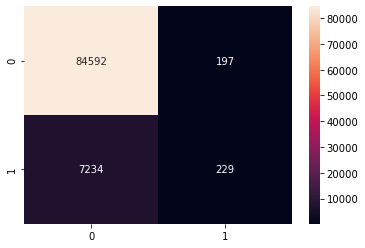

In [24]:
%%time
from sklearn.linear_model import LogisticRegression 

lr = LogisticRegression()      

lr_data = lr.fit(X_train, y_train)

lr_y_pred = lr_data.predict(X_test)

accuracy_and_cofusion_matrix(lr_data, X_test, y_test)


### Decision Tree

Test accuracy:  0.9168690109699519
Precision:  0.3498542274052478
Recall: 0.03215864933672786
F1 score:  0.05890293287519942
ROC :  0.5134492665240291
Log_Loss :  2.871246507317174


Wall time: 7min 32s


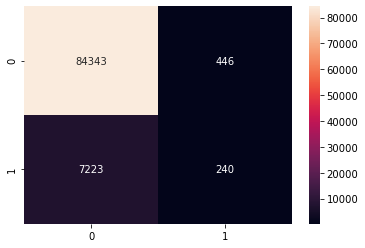

In [25]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=1)
dt_parameters = {'max_depth': [8], 'min_samples_leaf': [10]}

dt_grid = GridSearchCV(dt, dt_parameters, cv=10, refit='True', n_jobs=-1, verbose=0, scoring='roc_auc')
dt_grid.fit(X_train, y_train)
dt_model = dt_grid.best_estimator_

dt_y_pred = dt_model.predict(X_test)

accuracy_and_cofusion_matrix(dt_model, X_test, y_test)

### Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameter: {'max_depth': 10, 'max_features': 8, 'min_samples_split': 10, 'n_estimators': 1000}
Test accuracy:  0.9191020248883494
Precision:  0.0
Recall: 0.0
F1 score:  0.0
ROC :  0.5
Log_Loss :  2.7941170731823535


Wall time: 42min 44s


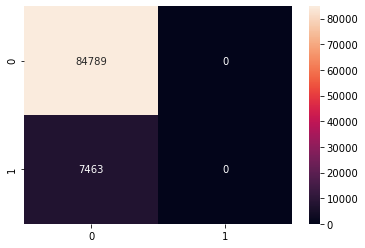

In [26]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_parameters = {"max_depth": [10], "max_features": [8], "n_estimators": [1000], "min_samples_split": [10]}  #reduced parameter for shorter runtime
rf_model = RandomForestClassifier()

rf_model_grid = GridSearchCV(rf_model, rf_parameters, cv=5, n_jobs=-1, verbose = 1)
rf_model_grid.fit(X_train, y_train)

print("Best parameter: " + str(rf_model_grid.best_params_))

rf_tuned = RandomForestClassifier(max_depth = rf_model_grid.best_params_["max_depth"], max_features = rf_model_grid.best_params_["max_features"], 
                                  min_samples_split = rf_model_grid.best_params_["min_samples_split"], n_estimators = rf_model_grid.best_params_["n_estimators"])
rf_tuned_data = rf_tuned.fit(X_train, y_train)

rf_tuned_y_pred = rf_tuned_data.predict(X_test)

accuracy_and_cofusion_matrix(rf_tuned_data,X_test, y_test)

### Extra Trees

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameter: {'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 300}
Test accuracy:  0.9191020248883494
Precision:  0.0
Recall: 0.0
F1 score:  0.0
ROC :  0.5
Log_Loss :  2.7941170731823535


Wall time: 46min 19s


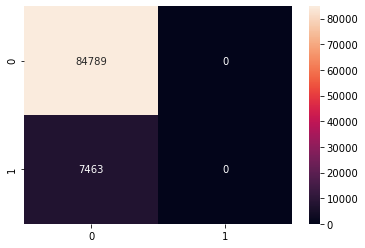

In [27]:
%%time
from sklearn.ensemble import ExtraTreesClassifier

XT_clf = ExtraTreesClassifier(random_state = 1, class_weight = {0: 11.5, 1:1})                     

XT_params={
        'n_estimators': [300],
        'min_samples_leaf': [18],
        'min_samples_split': [8],
    },

XT_grid = GridSearchCV(XT_clf, XT_params, cv=5, refit='True', n_jobs=-1, verbose=1)
XT_grid.fit(X_train, y_train)

print("Best parameter: " + str(XT_grid.best_params_))

XT_y_pred = XT_grid.predict(X_test)

accuracy_and_cofusion_matrix(XT_grid, X_test, y_test)

### XG Boost

[18:59:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameter: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}
Test accuracy:  0.9196982179248147
Precision:  0.5766016713091922
Recall: 0.027736835052927778
F1 score:  0.052927639989772436
ROC :  0.5129720748405022
Log_Loss :  2.7735266126729807


Wall time: 56min 22s


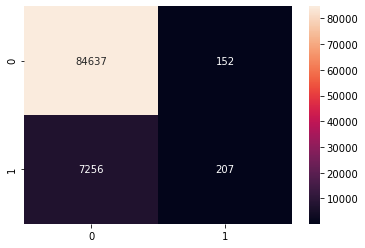

In [28]:
%%time
from xgboost import XGBClassifier

XGB_clf = XGBClassifier() 
XGB_parameters = {'max_depth': [6], 'n_estimators' : [200], 'learning_rate' : [0.05], 'gamma' : [0]}

XGB_grid = GridSearchCV(XGB_clf, XGB_parameters, cv=5, n_jobs=-1, verbose=0)
XGB_grid.fit(X_train, y_train)

print("Best parameter: " + str(XGB_grid.best_params_))

XGB_y_pred = XGB_grid.predict(X_test)

accuracy_and_cofusion_matrix(XGB_grid, X_test, y_test)

### Light GBM

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
Best parameter: {'learning_rate': 0.02}
Test accuracy:  0.7431383601439535
Precision:  0.19263831559813685
Recall: 0.6816293715663942
F1 score:  0.3003838204901092
ROC :  0.7150908300943695
Log_Loss :  8.871871535262274


Wall time: 11min 52s


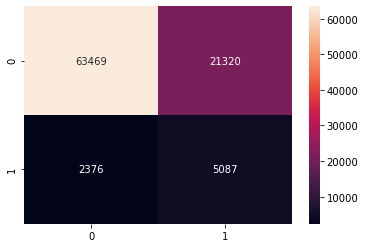

In [31]:
%%time

from lightgbm import LGBMClassifier

params = {'boosting_type': 'gbdt', 'objective': 'binary', 'max_depth': 18,                        # choices for boosting type are 'gbdt', 'rf', 'dart', 'goss'
          'nthread': -1, 'num_leaves': 30, 'learning_rate': 0.02, 'n_estimators' : 1600,          # default learning rate is 0.1 but tried 0.02 
          'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.8,
          'subsample_freq': 1, 'colsample_bytree': 0.8, 
          'reg_alpha': 80, 'reg_lambda': 20,                                                      # bumping up the alpha parameter gave us a little boost
          'min_split_gain': 0.5, 'min_child_weight': 1,
          'min_child_samples': 10, 'scale_pos_weight': 11.5, 'num_class' : 1,                     # about 92% target=0 to 8% target=1 - ratio is about 11.5 to 1
          'metric' : 'auc'
          }
    
LGB_clf = LGBMClassifier(**params)
LGB_parameters = {'learning_rate': [0.02]}

LGB_grid = GridSearchCV(LGB_clf, LGB_parameters, cv=5)

LGB_data = LGB_grid.fit(X_train, y_train)

print("Best parameter: " + str(LGB_grid.best_params_))

LGB_y_pred = LGB_data.predict(X_test)

accuracy_and_cofusion_matrix(LGB_data, X_test, y_test)

# 7. Model Evaluation and Selection

In [40]:
pd.set_option('display.max_colwidth', None)             # LGBM in particular has long hyperparameters and I want to see them all
model_results = pd.DataFrame(columns = ['Model', 'Accuracy','ROC','Precision', 'Recall','F1 Score','Log_Loss'])

In [41]:

data = {
                'Logistic Regression': lr_y_pred,                 
                'Decision Tree' : dt_y_pred,                  
                'Random Forest': rf_tuned_y_pred, 
                'Extra Tree': XT_y_pred,                 
                'XGBoost' : XGB_y_pred,                 
                'Light GBM' : LGB_y_pred
            }

models = pd.DataFrame(data) 
 
for column in models:
    CM=confusion_matrix(y_test,models[column])
        
    loss_log = log_loss(y_test, models[column])
    acc= accuracy_score(y_test, models[column])
    roc=roc_auc_score(y_test, models[column])
    prec = precision_score(y_test, models[column])
    rec = recall_score(y_test, models[column])
    f1 = f1_score(y_test, models[column])

    results =pd.DataFrame([[column,acc, roc, prec,rec, f1, loss_log]],
               columns = ['Model', 'Accuracy','ROC','Precision', 'Recall','F1 Score','Log_Loss'])
    model_results = model_results.append(results, ignore_index = True).drop_duplicates()
    
model_results

,Model,Accuracy,ROC,Precision,Recall,F1 Score,Log_Loss
0,Logistic Regression,0.919449,0.514181,0.537559,0.030685,0.058056,2.782138
1,Decision Tree,0.916869,0.513449,0.349854,0.032159,0.058903,2.871247
2,Random Forest,0.919102,0.500000,0.000000,0.000000,0.000000,2.794117
3,Extra Tree,0.919102,0.500000,0.000000,0.000000,0.000000,2.794117
4,XGBoost,0.919698,0.512972,0.576602,0.027737,0.052928,2.773527
5,Light GBM,0.743138,0.715091,0.192638,0.681629,0.300384,8.871872


From this data Light Gradient Boosting Machine has the highest ROC score and the accuracy is not bad as well

### Feature Importance

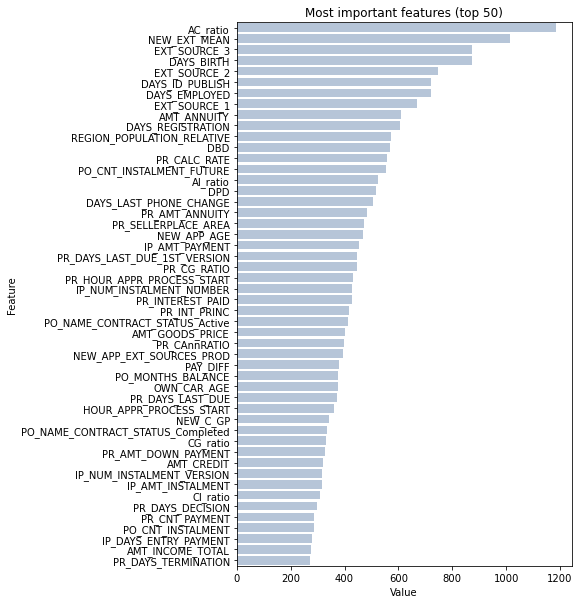

In [36]:
# Selecting feature based on LGBM as it gives much better roc score compare to the rest
LGB_model = LGB_grid.best_estimator_
LGB_model.fit(X_train, y_train)
feature_imp = pd.DataFrame(zip(LGB_model.feature_importances_, X), columns=['Value','Feature']).sort_values(by="Value", ascending=False)

plot_data = feature_imp.iloc[0:50,:]
plt.figure(figsize=[6,10])
sns.barplot(plot_data['Value'], plot_data['Feature'], orient = "h", color = "lightsteelblue")
plt.title("Most important features (top 50)")
plt.show()

# Conclusion

* Because of the unbalanced distribution of the target values, we scored our models based on area under the curve and not accuracy.
* Best performing model on validation was a Light GBM model.